https://www.kaggle.com/me/account

In [ ]:
from google.colab import files # чтобы загружать файлы в облако через проводник
uploaded = files.upload() #просто запускаем и выбираем файл  API токена в проводнике

#↓ строка которая активирует наш API токен
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#↓ добавился восклицательный знак, потому что это колаб
!kaggle competitions download -c urfuaieng2022reg2

 83% 35.0M/42.1M [00:00<00:00, 94.6MB/s]
100% 42.1M/42.1M [00:00<00:00, 80.1MB/s]


https://www.kaggle.com/competitions/urfuaieng2022reg2/data

In [ ]:
#↓ "распакуй" + имя архива
!unzip urfuaieng2022reg2.zip

Archive:  urfuaieng2022reg2.zip
  inflating: Submission_reg.csv      
  inflating: Test_Who.csv            
  inflating: Train_Target_reg.csv    
  inflating: Train_Who.csv           
  inflating: assessments.csv         
  inflating: courses.csv             
  inflating: studentAssessment.csv   
  inflating: studentInfo.csv         
  inflating: studentRegistration.csv  
  inflating: studentVle.csv          
  inflating: vle.csv                 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats

from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
# альтернативно можно использовать StratifiedKFold т.к. задача классификации
import seaborn as sns # чтобы подкрасить таблички

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)


## Некоторые полезные функции для анализа табличек между собой

# Загружаем данные в Pandas

In [ ]:
# данные которые "все"
ass = pd.read_csv('/content/assessments.csv')
courses = pd.read_csv('/content/courses.csv')
results = pd.read_csv('/content/studentAssessment.csv')
info = pd.read_csv('/content/studentInfo.csv')
reg = pd.read_csv('/content/studentRegistration.csv')
vle = pd.read_csv('/content/studentVle.csv')
materials = pd.read_csv('/content/vle.csv')

## Assessments info (информация об оценках)

1. **code_module** – идентификационный код модуля, которому принадлежит оценка.
2. **code_presentation** - идентификационный код презентации, к которой относится оценка.
3. **id_assessment** – идентификационный номер оценки.
4. **assessment_type** – вид оценки. Существует три типа оценок: оцениваемая репетитором (TMA), компьютерная оцениваемая оценка (CMA) и итоговый экзамен (Exam).
5. **date** – информация об окончательной дате сдачи оценки, рассчитанная как количество дней с момента начала модуля-презентации. Дата начала презентации имеет номер 0 (ноль).
6. **weight** - вес оценки в %. Обычно Экзамены обрабатываются отдельно и имеют вес 100%; сумма всех остальных оценок равна 100%.

In [ ]:
ass.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
ass['id_assessment'] = ass['id_assessment'].astype(object)
ass.head(2) # Метод .head() - первые 5 строк

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0


## Assessments results (результаты оценки)

1. **id_assessment** – идентификационный номер оценки.
2. **id_student** –уникальный идентификационный номер студента.
3. **date_submitted** – дата представления студентом, измеряемая как количество дней с начала презентации модуля.
4. **is_banked** – флаг состояния, указывающий, что результат оценки был перенесен из предыдущей презентации.

In [ ]:
results.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   id_assessment   173912 non-null  int64
 1   id_student      173912 non-null  int64
 2   date_submitted  173912 non-null  int64
 3   is_banked       173912 non-null  int64
dtypes: int64(4)
memory usage: 5.3 MB


In [ ]:
results['id_assessment'] = results['id_assessment'].astype(object)
results['id_student'] = results['id_student'].astype(object)
results.head(2)  # Метод .head() - первые 5 строк

,id_assessment,id_student,date_submitted,is_banked
0,1752,11391,18,0
1,1752,28400,22,0


## Courses info (информация о курсах)

1. **code_module** – кодовое имя модуля, которое служит идентификатором.
2. **code_presentation** – кодовое название презентации. Он состоит из года и «B» для презентации, начинающейся в феврале, и «J» для презентации, начинающейся в октябре.
3. **module_presentation_length** - длина модуля-презентации в днях.

In [ ]:
courses.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [ ]:
courses.head(2) # Метод .head() - первые 5 строк

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269


## Student registration (регистрация студентов)

1. **code_module** – идентификационный код модуля.
2. **code_presentation** - идентификационный код презентации.
3. **id_student** – уникальный идентификационный номер студента.
4. **date_registration** – дата регистрации студента на презентацию модуля, это количество дней, измеренное относительно начала презентации модуля (например, отрицательное значение -30 означает, что студент зарегистрировался на презентацию модуля за 30 дней до ее начала).

In [ ]:
reg.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        32593 non-null  object 
 1   code_presentation  32593 non-null  object 
 2   id_student         32593 non-null  int64  
 3   date_registration  32548 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1018.7+ KB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
reg['id_student'] = reg['id_student'].astype(object)
reg.head(2) # Метод .head() - первые 5 строк

,code_module,code_presentation,id_student,date_registration
0,AAA,2013J,11391,-159.0
1,AAA,2013J,28400,-53.0


## VLE resources

1. **id_site** - идентификационный номер материала.
2. **code_module** – идентификационный код модуля.
3. **code_presentation** - идентификационный код презентации.
4. **activity_type** – роль, связанная с материалом модуля.
5. **week_from** – неделя, с которой планируется использовать материал.
6. **week_to** – неделя, до которой планируется использовать материал.

In [ ]:
materials.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
materials['id_site'] = materials['id_site'].astype(object)
materials.head(2) # Метод .head() - первые 5 строк

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN


## VLE Interactions

1. **code_module** – идентификационный код модуля.
2. **code_presentation** - идентификационный код представления модуля.
3. **id_student** – уникальный идентификационный номер студента.
4. **id_site** - идентификационный номер материала VLE.
5. **date** – дата взаимодействия студента с материалом измеряется как количество дней с начала модуля-презентации.
6. **sum_click** – сколько раз учащийся взаимодействовал с материалом в этот день.

In [ ]:
vle.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB




```
487 MB, карл
```



Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
vle['id_student'] = vle['id_student'].astype(object)
vle['id_site'] = vle['id_site'].astype(object)
vle.head(2) # Метод .head() - первые 5 строк

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1


## Student information

1. **code_module** – идентификационный код модуля, на котором зарегистрирован студент.
2. **code_presentation** - идентификационный код презентации, во время которой студент регистрируется на модуле.
3. **id_student** – уникальный идентификационный номер студента.
4. **gender** – пол ученика.
5. **region** – определяет географический регион, в котором студент проживал во время прохождения модуля-презентации.
6. **highest_education** – самый высокий уровень образования студента при поступлении на модульную презентацию.
7. **imd_band** – задает диапазон [Index of Multiple Depravation](https://en.wikipedia.org/wiki/Multiple_deprivation_index#:~:text=Indices%20of%20multiple%20deprivation%20(IMD,a%20single%20score%20of%20deprivation.) места, где студент проживал во время модуля-презентации. (насколько бедный район, короче)
8. **age_band** – диапазон студенческого возраста.
9. **num_of_prev_attempts** – количество раз, когда учащийся пытался пройти этот модуль.
10. **studied_credits** – общее количество кредитов по модулям, которые студент изучает в настоящее время.
11. **disability** – указывает, признан ли студент инвалидом.

In [ ]:
info.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.7+ MB


Чтобы потом не путаться спрячем id-шники в тип данных "объект"

In [ ]:
info['id_student'] = info['id_student'].astype(object)
info.head(2)  # Метод .head() - первые 5 строк

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N


In [ ]:
info.gender.value_counts()

M    17875
F    14718
Name: gender, dtype: int64

<Axes: xlabel='age_band'>

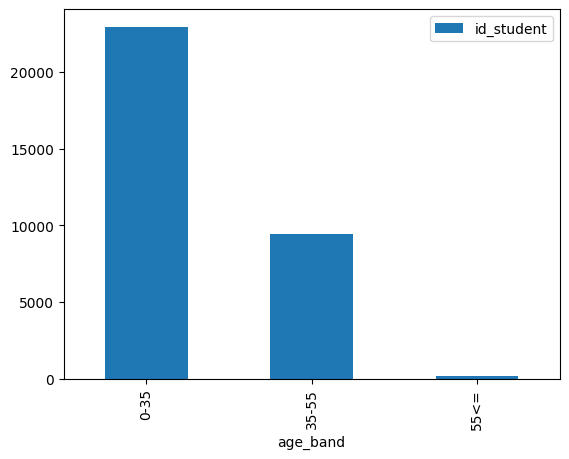

In [ ]:
info[['id_student', 'age_band']].groupby(by='age_band').count().plot.bar()

<Axes: ylabel='region'>

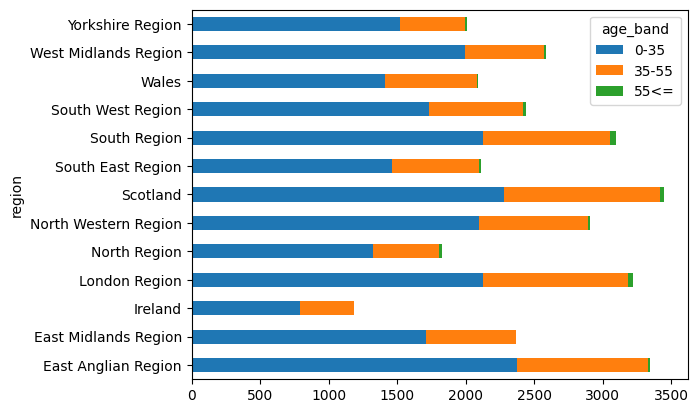

In [ ]:
pd.crosstab(info.region, info.age_band).plot.barh(stacked = True)

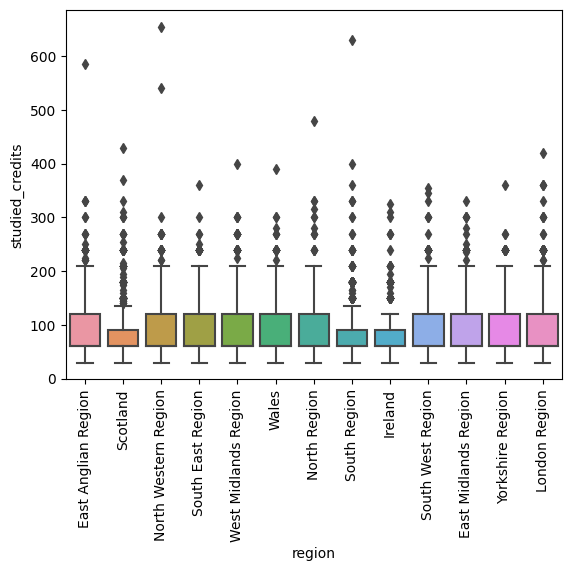

In [ ]:
sns.boxplot(x = 'region', y = 'studied_credits', data=info)
plt.xticks(rotation = 90)
plt.show()

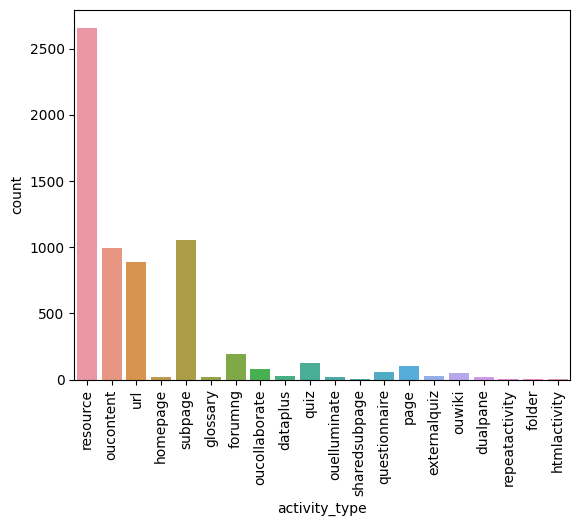

In [ ]:
sns.countplot(x="activity_type",data=materials)
plt.xticks(rotation = 90)
plt.show()

## Регистрация + Информация о курсах

In [ ]:
#                                     ↓ по каким колонкам буддем объединять     ↓ как
regCourses = pd.merge(reg, courses, on=['code_module', 'code_presentation'], how='inner')

regCourses.head(2)

,code_module,code_presentation,id_student,date_registration,module_presentation_length
0,AAA,2013J,11391,-159.0,268
1,AAA,2013J,28400,-53.0,268


## Регистрация + Информация о курсах + Инфа о студентах

In [ ]:
#                                     ↓ по каким колонкам буддем объединять                       ↓ как
regCoursesInfo = pd.merge(regCourses, info, on=['code_module', 'code_presentation', 'id_student'], how='inner')

regCoursesInfo.tail(2)

,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
32591,GGG,2014J,2679821,-49.0,269,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N
32592,GGG,2014J,2684003,-28.0,269,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N


<Axes: >

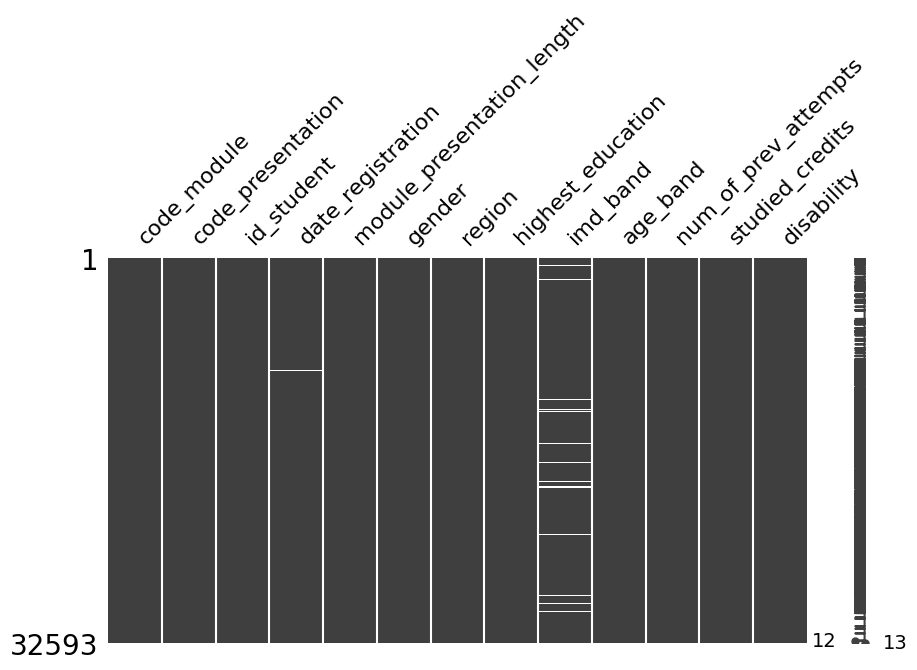

In [ ]:
import missingno as mn
mn.matrix(regCoursesInfo, figsize=(10,5))

In [ ]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(regCoursesInfo)
#profile

In [ ]:
regCoursesInfo.shape

(32593, 13)

#генерация признак-1

In [ ]:
studentVle_df = vle.merge(materials, on = 'id_site', how = 'left')
studentInteractivity_df = studentVle_df[['id_student',
                                     'activity_type', 'sum_click']].groupby(['id_student', 'activity_type']).mean()
studentInteractivity_df = studentInteractivity_df.reset_index()
studentInteractivity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220871 entries, 0 to 220870
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_student     220871 non-null  int64  
 1   activity_type  220871 non-null  object 
 2   sum_click      220871 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.1+ MB


In [ ]:
studentInteractivity_df = studentInteractivity_df.pivot(index='id_student',
                                                    columns='activity_type', values='sum_click')
studentInteractivity_df = studentInteractivity_df.reset_index()
studentInteractivity_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26074 entries, 0 to 26073
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_student      26074 non-null  int64  
 1   dataplus        2697 non-null   float64
 2   dualpane        3687 non-null   float64
 3   externalquiz    4685 non-null   float64
 4   folder          1934 non-null   float64
 5   forumng         23512 non-null  float64
 6   glossary        5978 non-null   float64
 7   homepage        26037 non-null  float64
 8   htmlactivity    1918 non-null   float64
 9   oucollaborate   10288 non-null  float64
 10  oucontent       24281 non-null  float64
 11  ouelluminate    2501 non-null   float64
 12  ouwiki          10402 non-null  float64
 13  page            8327 non-null   float64
 14  questionnaire   4476 non-null   float64
 15  quiz            18291 non-null  float64
 16  repeatactivity  3 non-null      float64
 17  resource        24896 non-null 

In [ ]:

def nan_values_handle(data):
  print("missing_values")
  print("data_shape :" ,data.shape)
  percent_missing = data.isnull().sum() * 100 / len(data)
  missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
  display(missing_value_df.sort_values(ascending=False,by="percent_missing")[:50])

  print("drop_cols_with_more_then_nan_values_0.25%")
  missing_data_high=missing_value_df["percent_missing"]>61
  display(missing_data_high[missing_data_high==True].index)

  drop_cols=missing_data_high[missing_data_high==True].index
  data.drop(drop_cols,axis=1,inplace=True)
  display(data.shape)
  return data


In [ ]:
studentInteractivity_df=nan_values_handle(studentInteractivity_df)

missing_values
data_shape : (26074, 21)


,column_name,percent_missing
activity_type,,
repeatactivity,repeatactivity,99.988494
sharedsubpage,sharedsubpage,99.512925
htmlactivity,htmlactivity,92.644013
folder,folder,92.582649
ouelluminate,ouelluminate,90.408069
dataplus,dataplus,89.656363
dualpane,dualpane,85.859477
questionnaire,questionnaire,82.833474
externalquiz,externalquiz,82.031909


drop_cols_with_more_then_nan_values_0.25%


Index(['dataplus', 'dualpane', 'externalquiz', 'folder', 'glossary',
       'htmlactivity', 'ouelluminate', 'page', 'questionnaire',
       'repeatactivity', 'sharedsubpage'],
      dtype='object', name='activity_type')

(26074, 10)

In [ ]:
def filling_missing_values(data):
  num_cols =data.select_dtypes(include=np.number).columns
  cat_cols = data.columns[data.dtypes == 'object']
  print(print("size_of_num_and_cat_cols" ), len(num_cols),len(cat_cols))
  percent_missing = data.isnull().sum() * 100 / len(data)
  missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
  #print("cat_cols_missing_percentage")
  #display(missing_value_df.loc[cat_cols].sort_values(ascending=False,by="percent_missing")[:10])

  miss_cat=missing_value_df.loc[cat_cols][percent_missing!=0]
  miss_num=missing_value_df.loc[num_cols][percent_missing!=0]
  print("filling_columns_cat")
  display(miss_cat)
  print("filling_columns_num")
  display(miss_num)
  #strategy_for_categorial_feature
  imputer = SimpleImputer(strategy='most_frequent',missing_values=np.nan)
  data[miss_cat.index]=imputer.fit_transform(data[miss_cat.index])

  #strategy_for_numerical_feature
  imputer=KNNImputer(n_neighbors=29)
  data[num_cols]=imputer.fit_transform(data[num_cols])
  return data

In [ ]:
studentInteractivity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26074 entries, 0 to 26073
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_student     26074 non-null  int64  
 1   forumng        23512 non-null  float64
 2   homepage       26037 non-null  float64
 3   oucollaborate  10288 non-null  float64
 4   oucontent      24281 non-null  float64
 5   ouwiki         10402 non-null  float64
 6   quiz           18291 non-null  float64
 7   resource       24896 non-null  float64
 8   subpage        25343 non-null  float64
 9   url            21488 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.0 MB


In [ ]:

#strategy_for_numerical_feature
df=studentInteractivity_df.copy()
imputer=KNNImputer(n_neighbors=5)
df=imputer.fit_transform(df)
studentInteractivity_df=pd.DataFrame(df,columns=studentInteractivity_df.columns)
studentInteractivity_df.head(2)

activity_type,id_student,forumng,homepage,oucollaborate,oucontent,ouwiki,quiz,resource,subpage,url
0,6516.0,2.577143,3.145570,1.280556,8.179348,4.055335,4.399264,1.631579,1.958904,2.918367
1,8462.0,1.809524,3.603774,1.625000,2.461538,3.600000,6.829697,1.372549,1.991228,1.352941


In [ ]:

studentInteractivity_df["Total"] = (
      studentInteractivity_df['forumng']
    + studentInteractivity_df["homepage"]
    + studentInteractivity_df["oucontent"]
    + studentInteractivity_df["quiz"]
    + studentInteractivity_df["ouwiki"]
    + studentInteractivity_df["resource"]
    + studentInteractivity_df["subpage"]
    + studentInteractivity_df["url"]
)


In [ ]:
studentInteractivity_df.head(2)

activity_type,id_student,forumng,homepage,oucollaborate,oucontent,ouwiki,quiz,resource,subpage,url,Total
0,6516.0,2.577143,3.145570,1.280556,8.179348,4.055335,4.399264,1.631579,1.958904,2.918367,28.865510
1,8462.0,1.809524,3.603774,1.625000,2.461538,3.600000,6.829697,1.372549,1.991228,1.352941,23.021251


In [ ]:
studentInteractivity_df.columns[1:10]

Index(['forumng', 'homepage', 'oucollaborate', 'oucontent', 'ouwiki', 'quiz',
       'resource', 'subpage', 'url'],
      dtype='object', name='activity_type')

In [ ]:
studentInteractivity_df.drop(studentInteractivity_df.columns[1:10],axis=1,inplace=True)

#генерация признак-1

In [ ]:
group_9=vle.merge(studentInteractivity_df, on = ['id_student'], how='left')
group_9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10655280 entries, 0 to 10655279
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   code_module        object 
 1   code_presentation  object 
 2   id_student         int64  
 3   id_site            int64  
 4   date               int64  
 5   sum_click          int64  
 6   Click_Timing       object 
 7   Before_Clicks_1    int64  
 8   Total              float64
dtypes: float64(1), int64(5), object(3)
memory usage: 812.9+ MB


In [ ]:
student_vle_merge_studentInteractivity_df= group_9.groupby(['code_module', 'code_presentation', 'id_student']
                                          ,as_index=False)["Total"].sum()


In [ ]:
dataset=regCoursesInfo.merge(student_vle_merge_studentInteractivity_df, on = ['id_student','code_module', 'code_presentation'], how='left')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32593 entries, 0 to 32592
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32593 non-null  object 
 1   code_presentation           32593 non-null  object 
 2   id_student                  32593 non-null  object 
 3   date_registration           32548 non-null  float64
 4   module_presentation_length  32593 non-null  int64  
 5   gender                      32593 non-null  object 
 6   region                      32593 non-null  object 
 7   highest_education           32593 non-null  object 
 8   imd_band                    31482 non-null  object 
 9   age_band                    32593 non-null  object 
 10  num_of_prev_attempts        32593 non-null  int64  
 11  studied_credits             32593 non-null  int64  
 12  disability                  32593 non-null  object 
 13  Total                       292

#генерация признак-2-3

In [ ]:
StudentVle_=vle.copy()

In [ ]:

vle.date.value_counts(normalize=True)[:5]


18    0.009677
2     0.009625
17    0.009445
16    0.009279
3     0.008705
Name: date, dtype: float64

In [ ]:

group_7=StudentVle_.groupby(['code_module', 'code_presentation', 'id_student'],as_index=False)["date"].sum()
group_7

,code_module,code_presentation,id_student,date
0,AAA,2013J,11391,20018
1,AAA,2013J,28400,37407
2,AAA,2013J,30268,179
3,AAA,2013J,31604,70376
4,AAA,2013J,32885,32361
...,...,...,...,...
29223,GGG,2014J,2640965,273
29224,GGG,2014J,2645731,33874
29225,GGG,2014J,2648187,13930
29226,GGG,2014J,2679821,2240


In [ ]:
dataset=dataset.merge(group_7, on =['code_module', 'code_presentation', 'id_student'], how = 'left')


In [ ]:
vle['Click_Timing'] = ['Before' if date < 0 else 'After' for date in vle['date']]

vle['Before_Clicks_1']= np.where(vle['Click_Timing'] =='Before',
                                                 vle['sum_click'], 18)


 # Create a new dataframe by Grouping the columns

student_vle_merge_vle_group = vle.groupby(['code_module', 'code_presentation', 'id_student']
                                          ,as_index=False)[  'Before_Clicks_1'].sum()


dataset=dataset.merge(student_vle_merge_vle_group, on = ['id_student','code_module'	,'code_presentation'], how='left')


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32593 entries, 0 to 32592
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32593 non-null  object 
 1   code_presentation           32593 non-null  object 
 2   id_student                  32593 non-null  object 
 3   date_registration           32548 non-null  float64
 4   module_presentation_length  32593 non-null  int64  
 5   gender                      32593 non-null  object 
 6   region                      32593 non-null  object 
 7   highest_education           32593 non-null  object 
 8   imd_band                    31482 non-null  object 
 9   age_band                    32593 non-null  object 
 10  num_of_prev_attempts        32593 non-null  int64  
 11  studied_credits             32593 non-null  int64  
 12  disability                  32593 non-null  object 
 13  Total                       292

In [ ]:
new_df=dataset.copy()
new_df=filling_missing_values(new_df)

size_of_num_and_cat_cols
None 7 9
filling_columns_cat


,column_name,percent_missing
imd_band,imd_band,3.408707


filling_columns_num


,column_name,percent_missing
date_registration,date_registration,0.138066
Total,Total,10.324303
date,date,10.324303
Before_Clicks_1,Before_Clicks_1,10.324303


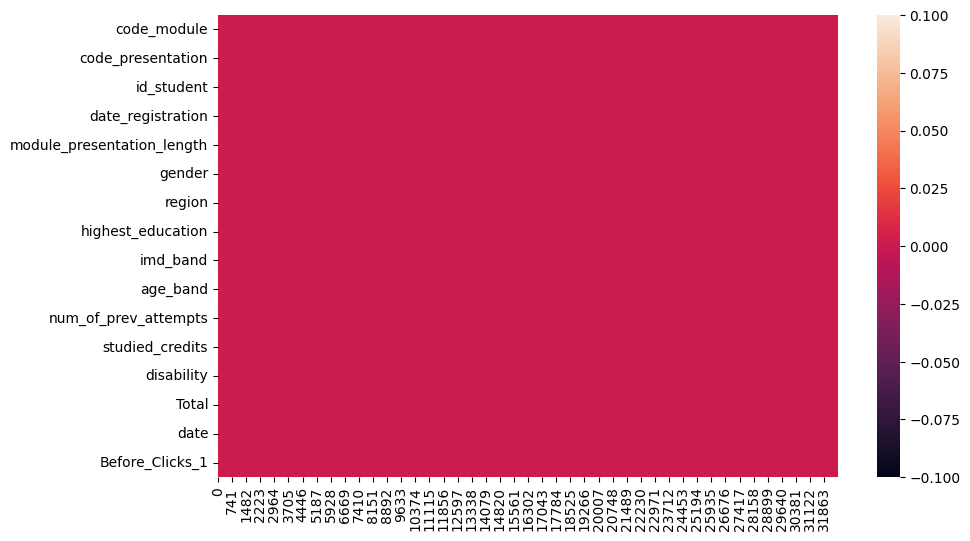

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(new_df.isna().transpose());

In [ ]:
new_df.drop("date_registration",axis=1,inplace=True)
new_df.drop("module_presentation_length",axis=1,inplace=True)
new_df.drop("num_of_prev_attempts",axis=1,inplace=True)
new_df.drop("studied_credits",axis=1,inplace=True)


# Выделение тренировочной и тестовой выборки

Список студентов, соответсвующих модулей и презентаций (разные студенты могут сдавать разные модули)

In [ ]:
Train_Who = pd.read_csv('/content/Train_Who.csv')
Test_Who = pd.read_csv('/content/Test_Who.csv')

In [ ]:
Train_Who.shape

(26074, 4)

In [ ]:
Train_Who.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26074 entries, 0 to 26073
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 26074 non-null  int64 
 1   id_student         26074 non-null  int64 
 2   code_module        26074 non-null  object
 3   code_presentation  26074 non-null  object
dtypes: int64(2), object(2)
memory usage: 814.9+ KB


А вот тут Left Join по всему содержимому `Train_Who`

Потому что мы не хотим ничего упустить оттуда

In [ ]:
#                                               ↓ по каким колонкам буддем объединять               ↓ как
Train = pd.merge(Train_Who, new_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
# Прячем "наш" ID в index фрейма
Train.index = Train.ID
# удаляем как столбец, ибо зачем
Train.drop(columns = ['ID'], inplace = True)
Train.tail(2)

,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,disability,Total,date,Before_Clicks_1
ID,,,,,,,,,,,,
26072,547448,DDD,2013J,M,South Region,Lower Than A Level,90-100%,35-55,N,17470.959489,73631.0,12074.0
26073,596855,CCC,2014J,M,South West Region,Lower Than A Level,60-70%,0-35,N,111.206120,38.0,72.0


In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26074 entries, 0 to 26073
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_student         26074 non-null  object 
 1   code_module        26074 non-null  object 
 2   code_presentation  26074 non-null  object 
 3   gender             26074 non-null  object 
 4   region             26074 non-null  object 
 5   highest_education  26074 non-null  object 
 6   imd_band           26074 non-null  object 
 7   age_band           26074 non-null  object 
 8   disability         26074 non-null  object 
 9   Total              26074 non-null  float64
 10  date               26074 non-null  float64
 11  Before_Clicks_1    26074 non-null  float64
dtypes: float64(3), object(9)
memory usage: 2.6+ MB


аналогично для тестовой выборки

In [ ]:
#                                               ↓ по каким колонкам буддем объединять               ↓ как
Test = pd.merge(Test_Who, new_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
# Прячем "наш" ID в index фрейма
Test.index = Test.ID
# удаляем как столбец, ибо зачем
Test.drop(columns = ['ID'], inplace = True)
Test.head(2)

,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,disability,Total,date,Before_Clicks_1
ID,,,,,,,,,,,,
26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,N,1407.484412,6553.000000,846.000000
26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,N,11721.808491,38732.862069,7066.758621


In [ ]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6519 entries, 26074 to 32592
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_student         6519 non-null   object 
 1   code_module        6519 non-null   object 
 2   code_presentation  6519 non-null   object 
 3   gender             6519 non-null   object 
 4   region             6519 non-null   object 
 5   highest_education  6519 non-null   object 
 6   imd_band           6519 non-null   object 
 7   age_band           6519 non-null   object 
 8   disability         6519 non-null   object 
 9   Total              6519 non-null   float64
 10  date               6519 non-null   float64
 11  Before_Clicks_1    6519 non-null   float64
dtypes: float64(3), object(9)
memory usage: 662.1+ KB


In [ ]:
Target = pd.read_csv('/content/Train_Target_reg.csv', index_col = 'ID')
Target.describe()

,weighted_score
count,26074.000000
mean,52.495302
std,29.724236
min,0.000000
25%,22.000000
50%,60.500000
75%,77.400000
max,100.000000


In [ ]:


df=pd.concat([Train,Target],axis=1)
display(df.head(2))

num_cols =df.select_dtypes(include=np.number).columns
cat_cols = df.columns[df.dtypes == 'object']

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")

df=df[num_cols]

corr_df=pd.DataFrame(df.corr()["weighted_score"].sort_values(ascending=False)[:15])
corr_df.style.background_gradient(cmap='Blues')

,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,disability,Total,date,Before_Clicks_1,weighted_score
ID,,,,,,,,,,,,,
0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,N,18441.808448,65566.0,10461.0,64.9125
1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,N,6193.674555,9671.0,5422.0,14.8625


We have 4 numeric columns: Total, date, Before_Clicks_1, weighted_score
And 9 categorical columns: id_student, code_module, code_presentation, gender, region, highest_education, imd_band, age_band, disability


,weighted_score
weighted_score,1.000000
date,0.494014
Before_Clicks_1,0.440336
Total,0.392904


<Axes: xlabel='Before_Clicks_1', ylabel='weighted_score'>

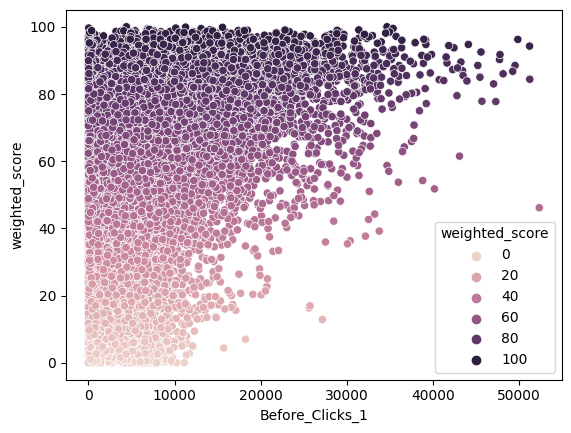

In [ ]:
sns.scatterplot(data=df,x=df["Before_Clicks_1"],y="weighted_score",hue="weighted_score")

<Axes: xlabel='date', ylabel='weighted_score'>

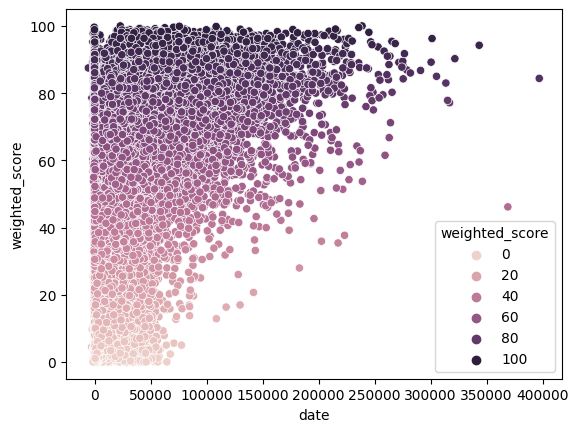

In [ ]:
sns.scatterplot(data=df,x="date",y="weighted_score",hue="weighted_score")

# Попытаемся слепить предсказание на коленке

Наверное использовать id студента - так себе вариант

Значит - удалим

In [ ]:
Train.drop(columns = ['id_student'], inplace = True)
Test.drop(columns = ['id_student'], inplace = True)

ружьё Чехова (не Бондурчука)

пригодилось то, что мы все id-шники закинули в тип данных `object`

теперь можем "автоматически" выполнять предварительную обработку по колонкам

In [ ]:

num_cols =Train.select_dtypes(include=np.number).columns
cat_cols = Train.columns[Train.dtypes == 'object']

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")

We have 3 numeric columns: Total, date, Before_Clicks_1
And 8 categorical columns: code_module, code_presentation, gender, region, highest_education, imd_band, age_band, disability


## наш старый друг Pipeline

In [ ]:
from sklearn.impute import SimpleImputer # Объект для замены пропущенных значений

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Импортируем нормализацию и One-Hot Encoding от scki-kit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

Создаем объект `Pipeline`

На вход ему подаем список из того, что мы хотим объединить в формате
* строка- название (даем имя Объекту)
* и сам объект (с заданными аргументами, если необходимо)

Сначала создадим отдельно Pipeline для числовых данных (вставление пропусков + нормализация)

In [ ]:
numerical_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    #('power', PowerTransformer()),
    ('scaler',   StandardScaler())
])

Предобработка категориальных данных (вставление пропусков + One-Hot кодирование)

In [ ]:
categorical_pipe = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])


Объект `ColumnTransformer` имеет в целом схожий синтаксис с `Pipeline`

т.е. на вход ему также подаем список из того, что мы хотим объединить в формате

* строка- название (даем имя Объекту)
* сам объект (в этом случае подаем объекты Pipeline)
* добавляется еще список названий столбцов, к которым мы применяем эти преобразования


In [ ]:
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])


"Обучаем" стандартно через `.fit()`

Тут важно, что на вход мы подаем датафреймы, т.к. в них есть колонки к которым мы обращаемся "по именам". Внимательно следите за названиями колонок, он проверяет всё добуквенно

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

In [ ]:
preprocessors.fit(Train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('poly',
                                                  PolynomialFeatures(degree=1)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Total', 'date', 'Before_Clicks_1'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['code_module', 'code_presentation', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'disability'],
      dtype='object'))])

In [ ]:
Train_ = preprocessors.transform(Train) # преобразуем  тренировочные данные

X_test = preprocessors.transform(Test) # преобразуем  тестовые данные

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import  RandomForestRegressor
from sklearn.linear_model import Ridge


class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = LinearRegression()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)


In [ ]:
from scipy.stats import norm, skew
import scipy.stats as stats
def diagnostic_plots(df, variable):
    plt.figure(figsize=(5,2))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

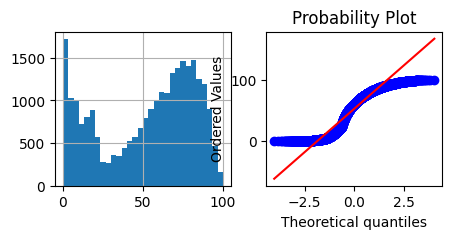

In [ ]:
y2=pd.DataFrame(Target.values)
diagnostic_plots(y2,0)

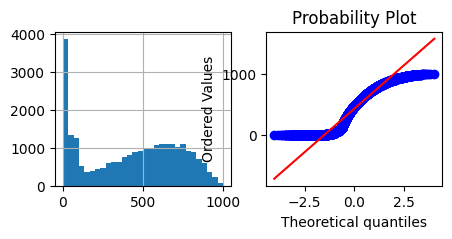

In [ ]:
y3=pd.DataFrame((np.sqrt(Target.values)**3))
diagnostic_plots(y3,0)

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(Train_,Target, test_size=0.2, random_state=42)

In [ ]:

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_val.shape)
print('Testing Labels Shape:', y_val.shape)

Training Features Shape: (20859, 48)
Training Labels Shape: (20859, 1)
Testing Features Shape: (5215, 48)
Testing Labels Shape: (5215, 1)


In [ ]:
sel_= SelectFromModel(Lasso(alpha=0.005,random_state=0))
# train Lasso model and select features
sel_.fit(X_train,y_train)
# let's print the number of total and selected features

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))

In [ ]:
# let's print the number of total and selected features
selected_feats = pd.DataFrame(X_train).columns[(sel_.get_support())]
# let's print some stats
print('Total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_== 0)))

Total features: 48
selected features: 42
features with coefficients shrank to zero: 6


In [ ]:
X_train=pd.DataFrame(X_train).iloc[:,selected_feats]
X_test=pd.DataFrame(X_test).iloc[:,selected_feats]
X_val=pd.DataFrame(X_val).iloc[:,selected_feats]

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_val.shape)
print('Testing Labels Shape:', y_val.shape)

Training Features Shape: (20859, 42)
Training Labels Shape: (20859, 1)
Testing Features Shape: (5215, 42)
Testing Labels Shape: (5215, 1)


In [ ]:

pipeline = Pipeline(steps=[
    ('model',  ClfSwitcher())
])

In [ ]:
from sklearn.model_selection import GridSearchCV # для поиска по сетке гиперпараметров
from sklearn.neighbors import KNeighborsRegressor # Регрессия К-Ближайших соседей от scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import StratifiedKFold # при кросс-валидации разбиваем данные в пропорции целевой метки
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn


In [ ]:
def plot_predict(y_test,predicted):
  A = np.array(y_test).reshape(-1, 1)
  B = predicted.reshape(-1, 1)

  print(type(predicted))
  print(type(y_test))
  plt.rcParams['figure.figsize'] = 16,5
  plt.figure()
  plt.plot(A[-100:], label="Real")
  plt.plot(B[-100:], label="Predicted")
  plt.legend()
  plt.title("score: real vs predicted")
  plt.ylabel("score")
  plt.xticks(())
  rmse = np.sqrt(mean_squared_error(y_test, predicted))

  print('RMSE: ',rmse)

  print('Variance score: %.2f' % r2_score(y_test, predicted))
  plt.show()


100%|██████████| 10/10 [01:28<00:00,  8.84s/it]


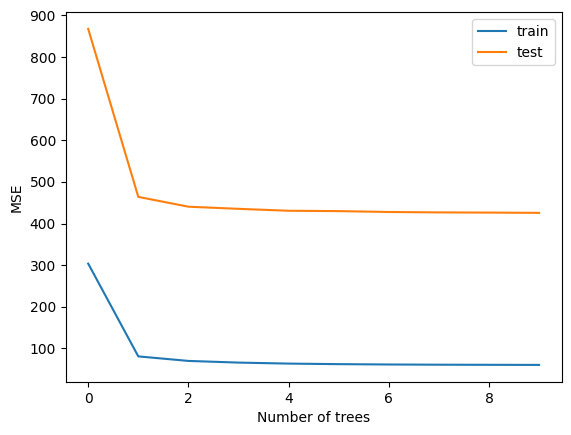

In [ ]:
from tqdm import tqdm

train_mse_, test_mse_ = [], []
n_trees = 100
from sklearn.metrics import mean_squared_error,r2_score
for i in tqdm(range(1, n_trees,10)):
    model = RandomForestRegressor(n_estimators=i, random_state=42)
    model.fit(X_train, y_train)
    train_mse_.append(mean_squared_error(y_train, model.predict(X_train)))
    test_mse_.append(mean_squared_error(y_val, model.predict(X_val)))

plt.plot(train_mse_, label='train')
plt.plot(test_mse_, label='test')
plt.xlabel('number of trees')
plt.ylabel('MSE')
plt.xlabel('Number of trees')
plt.legend();

In [ ]:
list(range(1, n_trees,10))

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91]

зафиксируем n_tree=29

100%|██████████| 8/8 [00:24<00:00,  3.10s/it]


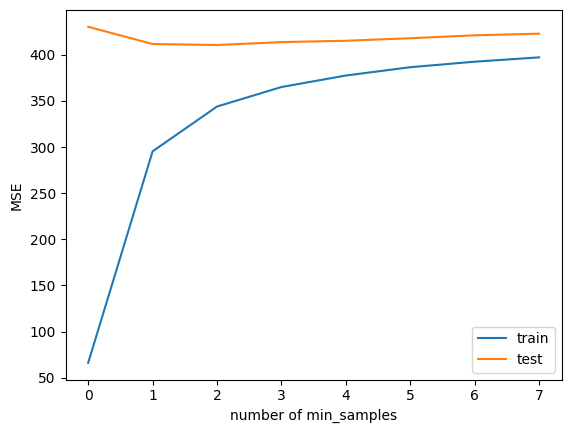

In [ ]:
from tqdm import tqdm
min_samples_leaf_array = range(1, 80,10)
train_mse_leaf= []
test_mse_leaf = []
for  min_samples_leaf in tqdm(min_samples_leaf_array):
    model = RandomForestRegressor(n_estimators=29, min_samples_leaf=min_samples_leaf, random_state=13)
    model.fit(X_train, y_train)
    train_mse_leaf.append(mean_squared_error(y_train, model.predict(X_train)))
    test_mse_leaf.append(mean_squared_error(y_val, model.predict(X_val)))

plt.plot(train_mse_leaf, label='train')
plt.plot(test_mse_leaf, label='test')
plt.xlabel('number of min_samples')
plt.ylabel('MSE')
plt.legend();

зафиксируем min_samples больше 80 так как где то они пересекаются





100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


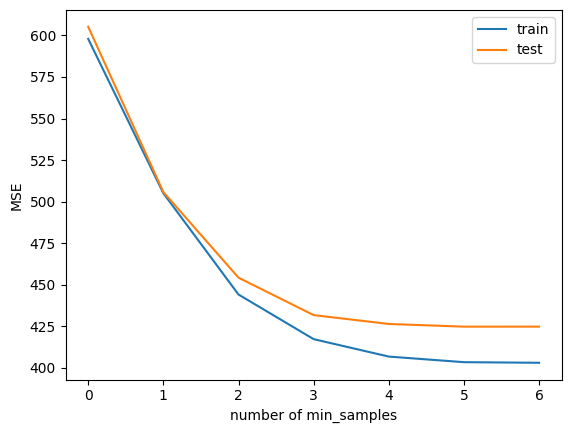

In [ ]:
max_depth_array = range(1, 15,2)
train_mse_depth_1 = []
test_mse_depth_1 = []
for  max_depth in tqdm(max_depth_array):
    model = RandomForestRegressor(n_estimators=29, min_samples_leaf=90,max_depth=max_depth, random_state=13)
    model.fit(X_train, y_train)
    train_mse_depth_1.append(mean_squared_error(y_train, model.predict(X_train)))
    test_mse_depth_1.append(mean_squared_error(y_val, model.predict(X_val)))

plt.plot(train_mse_depth_1, label='train')
plt.plot(test_mse_depth_1, label='test')
plt.xlabel('number of min_samples')
plt.ylabel('MSE')
plt.legend();

In [ ]:

model = RandomForestRegressor(n_estimators=29, min_samples_leaf=70 ,max_depth=9, random_state=13)
model.fit(X_train, y_train)
print(mean_squared_error(y_train, model.predict(X_train)))
print(mean_squared_error(y_val, model.predict(X_val)))

402.8146134241097
424.85637668849427


In [ ]:
# Number of trees in random forest
n_estimators =[int(x) for x in np.linspace(20, 50, num = 10)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 18, num =7)]
#max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(50, 100, num = 7)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
parameters = [
  {
        'model': (RandomForestRegressor(),),
        'model__n_estimators': n_estimators,
        'model__max_features': max_features,
        'model__max_depth': max_depth,
        'model__min_samples_leaf': min_samples_leaf,
        #'model__bootstrap': bootstrap,
    }
]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters,
                              n_iter = 100, scoring='neg_mean_squared_error',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
rf_random.best_params_

{'model__n_estimators': 43,
 'model__min_samples_leaf': 50,
 'model__max_features': 'auto',
 'model__max_depth': 18,
 'model': RandomForestRegressor(max_depth=18, max_features='auto', min_samples_leaf=50,
                       n_estimators=43)}

In [ ]:
best_= rf_random.best_estimator_ #RandomForestRegressor(max_depth=18, max_features='auto', min_samples_leaf=50,n_estimators=43)
best_.fit(X_train, y_train)
# предсказываем на тестовых данных
y_predict=best_.predict(X_val)

scoring = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}

# используем функцию кросс-валидации

scores = cross_validate(best_, # какую модель тестируем
                        X_train, y_train, # на каких данных
                      scoring=scoring,  #на каких метриках
                      # как разбиваем данные при кросс-валидации
                      cv=ShuffleSplit(n_splits=3, random_state=42),return_train_score=True)


print('Результаты Кросс-валидации')
DF_cv_forest = pd.DataFrame(scores)
display(DF_cv_forest)


print('Ошибка на тестовых данных')
print('MSE: %.4f' % mean_squared_error(y_val,y_predict))
print('RMSE: %.4f' % mean_squared_error(y_val,y_predict,squared=False))

print('R2 : %.4f' %  r2_score(y_val,y_predict))

Результаты Кросс-валидации


,fit_time,score_time,test_R2,train_R2,test_-MSE,train_-MSE,test_-MAE,train_-MAE,test_Max,train_Max
0,2.831355,0.021559,0.537045,0.561509,-410.597518,-386.103660,-15.313840,-14.785494,-86.217472,-85.270449
1,3.538829,0.027156,0.530515,0.561154,-412.937283,-386.773540,-15.361211,-14.800234,-87.831110,-84.213819
2,3.707182,0.057439,0.543950,0.558998,-401.876776,-388.590185,-15.218046,-14.834324,-73.973786,-85.315822


Ошибка на тестовых данных
MSE: 418.3424
RMSE: 20.4534
R2 : 0.5314


<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
RMSE:  20.45341945509497
Variance score: 0.53


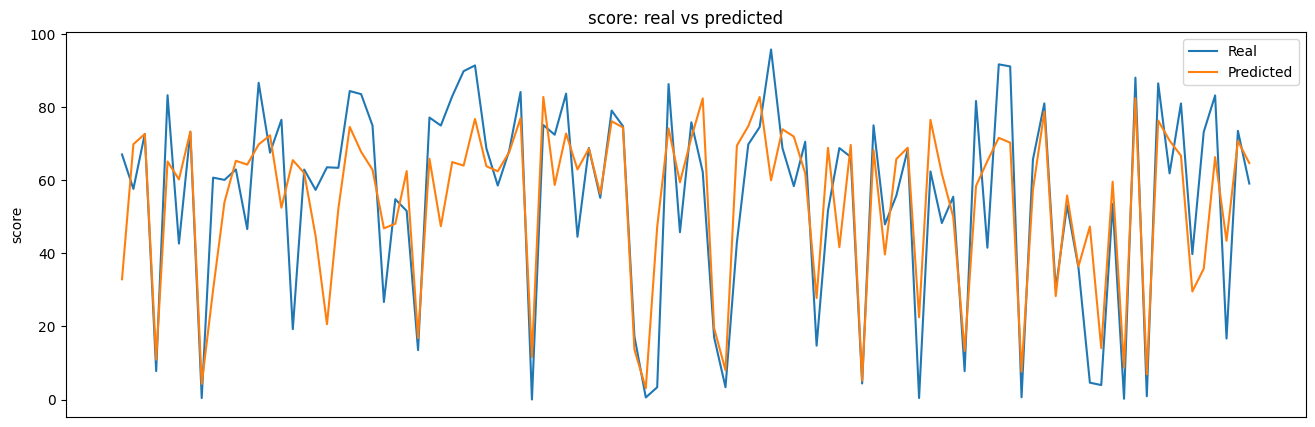

In [ ]:
plot_predict(y_val,y_predict)

#Lineer_Regresion and PCA

In [ ]:
from sklearn.decomposition import PCA
categorical_pipe = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])
numerical_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=4)),
    ('power', PowerTransformer()),
    ('scaler',   StandardScaler())
])
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])
preprocessors.fit(Train)
df1 = preprocessors.transform(Train)

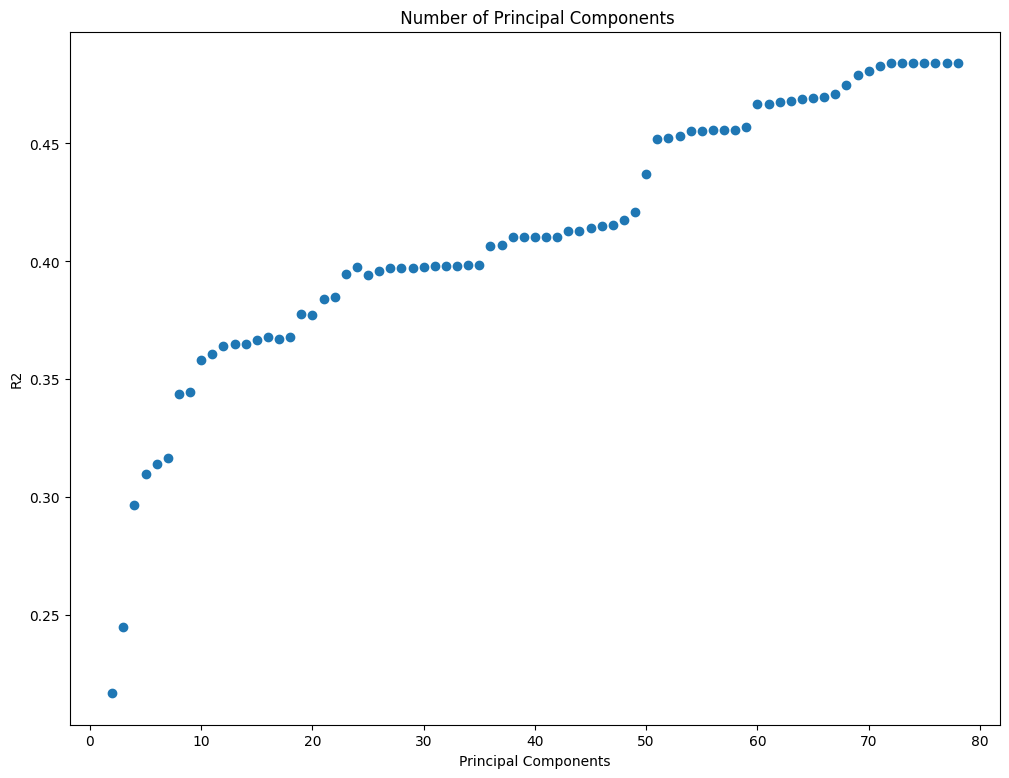

In [ ]:
X2=pd.DataFrame(df1)
def do_pca(n_components,X):
  pca=PCA(n_components)
  X_pca=pca.fit_transform(X2)
  return pca,X_pca



def fit_L_R(X, y, print_output=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)

    clf =LinearRegression()
    clf.fit(X_train, y_train)

    y_preds = clf.predict(X_test)

    R2=r2_score(y_test, y_preds)

    return R2


acc_list, pc_list = [], []
for pc in range(2,X2.shape[1]):
    pca, X_pca = do_pca(pc,X2)
    acc = fit_L_R(X_pca,Target)
    acc_list.append(acc)
    pc_list.append(pc)

plt.figure(figsize=[12,9])
plt.scatter(pc_list, acc_list)
plt.title(' Number of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('R2');

n_comp-72

In [ ]:
categorical_pipe = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])
numerical_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=4)),
    ('power', PowerTransformer()),
    ('PCA', PCA(n_components=29)),
    ('scaler',   StandardScaler())
])
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])
preprocessors.fit(Train)
df1 = preprocessors.transform(Train) # преобразуем  тренировочные данные
X_train, X_val, y_train, y_val = train_test_split(df1,Target, test_size=0.2, random_state=42)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_val.shape)
print('Testing Labels Shape:', y_val.shape)

Training Features Shape: (20859, 73)
Training Labels Shape: (20859, 1)
Testing Features Shape: (5215, 73)
Testing Labels Shape: (5215, 1)


In [ ]:
np.logspace(-1 ,2, 10)

array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ])

In [ ]:
parameters = [
    {
        'model': (Ridge(),),
        'model__alpha': np.logspace(-1, 2, 10),
        'model__fit_intercept':[True,False]
    },
    {
        'model': ( Lasso(),),
        'model__alpha': np.logspace(-1, 2, 10),
        'model__fit_intercept':[True,False]
    }
]

# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters,
                              n_iter = 100, scoring='neg_mean_squared_error',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [ ]:
rf_random.best_estimator_

Pipeline(steps=[('model', Ridge(alpha=100.0))])

In [ ]:
best_=rf_random.best_estimator_
best_.fit(X_train, y_train)
# предсказываем на тестовых данных
y_predict=best_.predict(X_val)

scoring = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}

# используем функцию кросс-валидации

scores = cross_validate(best_, # какую модель тестируем
                        X_train, y_train, # на каких данных
                      scoring=scoring,  #на каких метриках
                      # как разбиваем данные при кросс-валидации
                      cv=ShuffleSplit(n_splits=3, random_state=42),return_train_score=True)


print('Результаты Кросс-валидации')
DF_cv_forest = pd.DataFrame(scores)
display(DF_cv_forest)


print('Ошибка на тестовых данных')
print('MSE: %.4f' % mean_squared_error(y_val,y_predict))
print('RMSE: %.4f' % mean_squared_error(y_val,y_predict,squared=False))

print('R2 : %.4f' %  r2_score(y_val,y_predict))

Результаты Кросс-валидации


,fit_time,score_time,test_R2,train_R2,test_-MSE,train_-MSE,test_-MAE,train_-MAE,test_Max,train_Max
0,0.079481,0.021493,0.483326,0.480039,-458.240674,-457.840437,-16.410088,-16.526635,-103.901856,-155.391345
1,0.071909,0.014790,0.485179,0.479643,-452.812399,-458.612700,-16.481322,-16.528358,-107.021286,-154.625635
2,0.072476,0.013195,0.481117,0.478412,-457.245499,-459.598343,-16.496278,-16.584609,-192.901527,-169.236822


Ошибка на тестовых данных
MSE: 472.6166
RMSE: 21.7397
R2 : 0.4706


<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
RMSE:  21.7397472477775
Variance score: 0.47


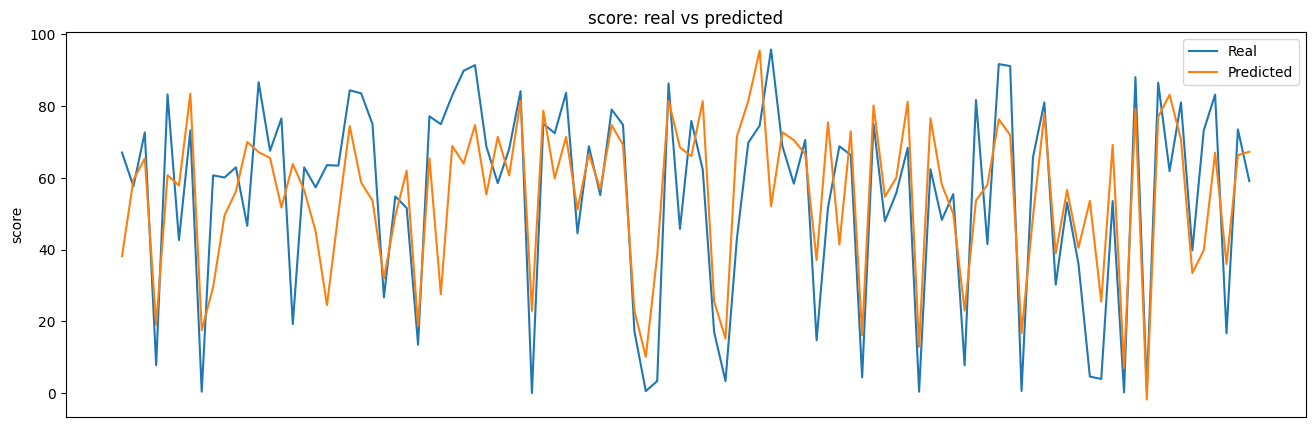

In [ ]:
plot_predict(y_val,y_predict)

#Random Forest poly(4)

In [ ]:
rf_random.best_params_


{'model__n_estimators': 46,
 'model__min_samples_leaf': 50,
 'model__max_features': 'auto',
 'model__max_depth': 18,
 'model': RandomForestRegressor(max_depth=18, max_features='auto', min_samples_leaf=50,
                       n_estimators=46)}

In [ ]:
best_=rf_random.best_estimator_
best_.fit(X_train, y_train)
# предсказываем на тестовых данных
y_predict=best_.predict(X_val)

scoring = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}

# используем функцию кросс-валидации

scores = cross_validate(best_, # какую модель тестируем
                        X_train, y_train, # на каких данных
                      scoring=scoring,  #на каких метриках
                      # как разбиваем данные при кросс-валидации
                      cv=ShuffleSplit(n_splits=3, random_state=42),return_train_score=True)


print('Результаты Кросс-валидации')
DF_cv_forest = pd.DataFrame(scores)
display(DF_cv_forest)


print('Ошибка на тестовых данных')
print('MSE: %.4f' % mean_squared_error(y_val,y_predict))
print('RMSE: %.4f' % mean_squared_error(y_val,y_predict,squared=False))

print('R2 : %.4f' %  r2_score(y_val,y_predict))

Результаты Кросс-валидации


,fit_time,score_time,test_R2,train_R2,test_-MSE,train_-MSE,test_-MAE,train_-MAE,test_Max,train_Max
0,20.796582,0.030377,0.535158,0.572767,-412.270725,-376.190618,-15.379907,-14.639123,-86.894253,-84.737196
1,29.049783,0.021211,0.530317,0.573285,-413.111716,-376.081527,-15.444490,-14.633029,-85.385911,-83.549482
2,20.443965,0.023547,0.533286,0.572664,-411.273620,-376.547972,-15.397205,-14.631813,-79.485375,-85.046799


Ошибка на тестовых данных
MSE: 419.9291
RMSE: 20.4922
R2 : 0.5297


In [ ]:
best_

Pipeline(steps=[('model',
                 RandomForestRegressor(max_depth=18, max_features='auto',
                                       min_samples_leaf=50, n_estimators=46))])

In [ ]:
X_train=pd.DataFrame(X_train)
best_=RandomForestRegressor(max_depth=18, max_features='auto', min_samples_leaf=50,
                      n_estimators=46).fit(X_train,y_train)
# предсказываем на тестовых данных
importances = list(best_.feature_importances_)
feature_list = list(X_train.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)


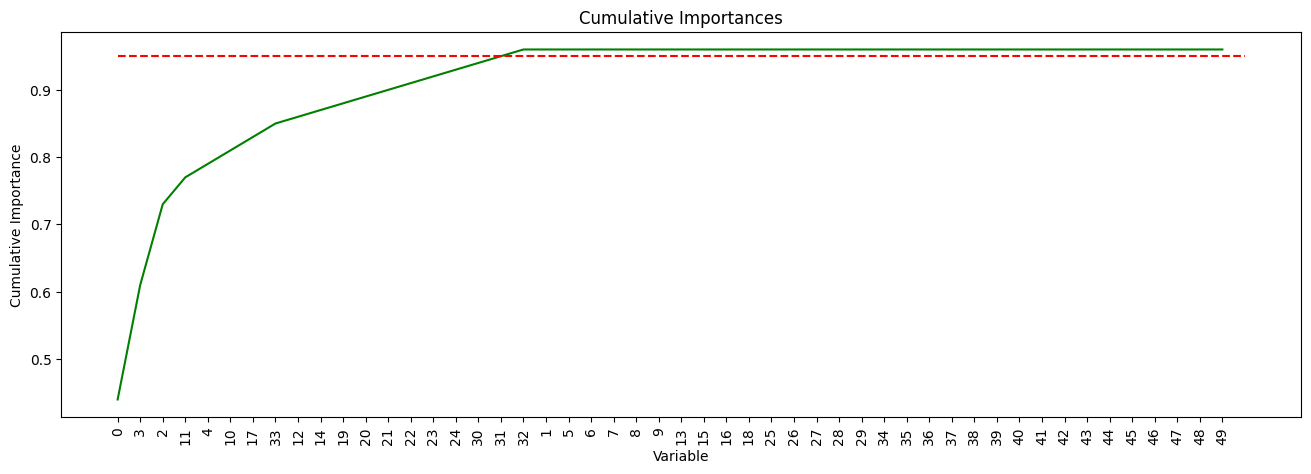

In [ ]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances][:50]
sorted_features = [importance[0] for importance in feature_importances][:50]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
x_values = list(range(len(importances)))
# Make a line graph
plt.plot(x_values[:50], cumulative_importances[:50], 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values[:50], sorted_features[:50], rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [ ]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 97% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 97% importance: 18


In [ ]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:18]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]


In [ ]:
# Create training and testing sets with only the important features
important_train_features = X_train[important_indices]
important_test_features = X_val[:,important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (20859, 18)
Important test features shape: (5215, 18)


#additional

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

model =  RandomForestRegressor(max_depth=18, max_features='auto', min_samples_leaf=50,
                       n_estimators=46)
regr_trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
yhat = regr_trans.predict(X_val)
round(r2_score(y_val, yhat), 3), round(mean_absolute_error(y_val, yhat), 2), round(np.sqrt(mean_squared_error(y_val, yhat)),2)

(0.503, 14.91, 21.06)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
def boost_models(x):
    regr_trans = TransformedTargetRegressor(regressor=x, transformer=QuantileTransformer(output_distribution='normal'))
    regr_trans.fit(X_train, y_train)
    yhat = regr_trans.predict(X_val)
    algoname= x.__class__.__name__
    return algoname, round(r2_score(y_val, yhat),3), round(mean_absolute_error(y_val, yhat),1), round(np.sqrt(mean_squared_error(y_val,yhat)),1)

In [ ]:
import xgboost as xg
import lightgbm as lgbm
algo=[GradientBoostingRegressor(), lgbm.LGBMRegressor(), xg.XGBRFRegressor()]
score=[]
for a in algo:
    score.append(boost_models(a))
pd.DataFrame(score, columns=['Model', 'Score', 'MAE', 'RMSE'])

,Model,Score,MAE,RMSE
0,GradientBoostingRegressor,0.475,15.1,21.7
1,LGBMRegressor,0.494,14.7,21.3
2,XGBRFRegressor,0.475,15.4,21.7


In [ ]:
# Number of trees in random forest
n_estimators =[int(x) for x in np.linspace(20, 200, num = 7)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 18, num =7)]

parameters = [
  {
        'model': (lgbm.LGBMRegressor(),),
        'model__n_estimators': n_estimators,
        'model__max_depth': max_depth,
        'model__num_leaves' :[50, 56, 60, 74],
       'model__learning_rate' :[0.05]
    }
]
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters,
                              n_iter = 100, scoring='neg_mean_squared_error',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

regr_trans = TransformedTargetRegressor(regressor=rf_random, transformer=QuantileTransformer(output_distribution='normal'))

# fitting the model for grid search
grid_result=regr_trans.fit(X_train, y_train)
best_params=grid_result.regressor_.best_params_
print(best_params)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'model__num_leaves': 56, 'model__n_estimators': 80, 'model__max_depth': 8, 'model__learning_rate': 0.05, 'model': LGBMRegressor(learning_rate=0.05, max_depth=8, n_estimators=80, num_leaves=56)}


In [ ]:
#using best params to create and fit model
best_model = lgbm.LGBMRegressor(max_depth=best_params["model__max_depth"], n_estimators=best_params["model__n_estimators"],
                                num_leaves=best_params["model__num_leaves"],
                                learning_rate=best_params["model__learning_rate"] )
regr_trans = TransformedTargetRegressor(regressor=best_model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
yhat = regr_trans.predict(X_val)

#evaluate metrics
r2_score(y_val, yhat), mean_absolute_error(y_val, yhat), np.sqrt(mean_squared_error(y_val, yhat))

(0.5031474887824551, 14.64628163371249, 21.06161161839276)

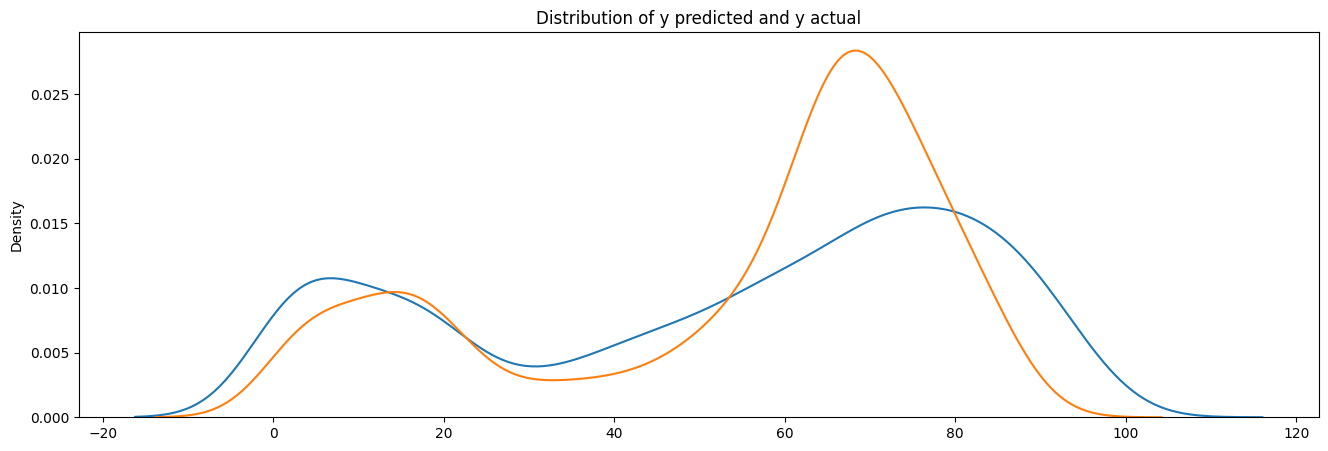

In [ ]:
plt.title("Distribution of y predicted and y actual")
ax1=sns.distplot(y_val, hist=False)
sns.distplot(yhat, hist=False, ax=ax1)
plt.show()

In [ ]:
predict_test=best_.predict(X_test)

In [ ]:
Submission = pd.read_csv('/content/Submission_reg.csv', index_col = 'ID')

In [ ]:
Submission['weighted_score'] = predict_test

In [ ]:
Submission['weighted_score'][:10]

In [ ]:
Submission.to_csv('/content/My_Submission_reg_final_2.csv',index=True) # если хотим чтобы и индексы сохранились - пишем index = True

In [ ]:
#                                ↓ соревнование         ↓ название файла     ↓ комментарий
!kaggle competitions submit -c urfuaieng2022reg2 -f My_Submission_reg_final_2.csv -m " regression test"